In [1]:
import cudf
import matplotlib.pyplot as plt
print(cudf.__version__)
import numpy as np
import cupy as cp
import pandas as pd
from tqdm import tqdm

23.04.01


In [2]:
chunk_size = 100000

chunks = []
panda2_path = '/workspaces/wiggle-face/data/panda_data/keypoints_clean_PANDA2_dataset.csv'

# read the CSV file in chunks (run for all 3 datasets)
for chunk in pd.read_csv(panda2_path, chunksize=chunk_size):
    # pandas DataFrame chunk to cuDF DataFrame
    cudf_chunk = cudf.DataFrame.from_pandas(chunk)
    chunks.append(cudf_chunk)

# concatenate
df = cudf.concat(chunks, ignore_index=True)

print(df.head())

   infant_id age_weeks  frame_id                                 keypoint  \
0          6     12-16        95  (343.6092224121094, 253.11997985839844)   
1          6     12-16        95    (342.382568359375, 262.9331359863281)   
2          6     12-16        95   (341.5647888183594, 272.3374328613281)   
3          6     12-16        95  (340.7470397949219, 281.33282470703125)   
4          6     12-16        95     (340.7470397949219, 291.14599609375)   

   keypoint_score face_part  keypoint_index  \
0        0.805525      Chin               1   
1        0.882583      Chin               2   
2        0.869565      Chin               3   
3        0.958641      Chin               4   
4        0.873230      Chin               5   

                        processed_keypoint  
0  (388.29339599609375, 264.0990244547526)  
1   (377.4019470214844, 263.0326182047526)  
2  (342.51885986328125, 263.0326182047526)  
3  (341.56479899088544, 272.2011311848958)  
4   (341.0196228027344, 281.6

In [3]:
# split the keypoint column into 2 columns for the x and y coordinates
df[['x_coordinate', 'y_coordinate']] = df['keypoint'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(np.float64)
df = df.drop(columns=['keypoint'])
df = df.sort_values(by=['infant_id','age_weeks', 'frame_id', 'keypoint_index']).reset_index(drop=True)
    
print(df.head(319))

     infant_id age_weeks  frame_id  keypoint_score    face_part  \
0            6     12-16        95        0.805525         Chin   
1            6     12-16        95        0.882583         Chin   
2            6     12-16        95        0.869565         Chin   
3            6     12-16        95        0.958641         Chin   
4            6     12-16        95        0.873230         Chin   
..         ...       ...       ...             ...          ...   
314          6     12-16        97        0.957227        Mouth   
315          6     12-16        97        0.943442        Mouth   
316          6     12-16        97        0.969353  Right_Pupil   
317          6     12-16        97        0.936225   Left_Pupil   
318          6     12-16        98        0.769301         Chin   

     keypoint_index                       processed_keypoint  x_coordinate  \
0                 1  (388.29339599609375, 264.0990244547526)    343.609222   
1                 2   (377.401947021484

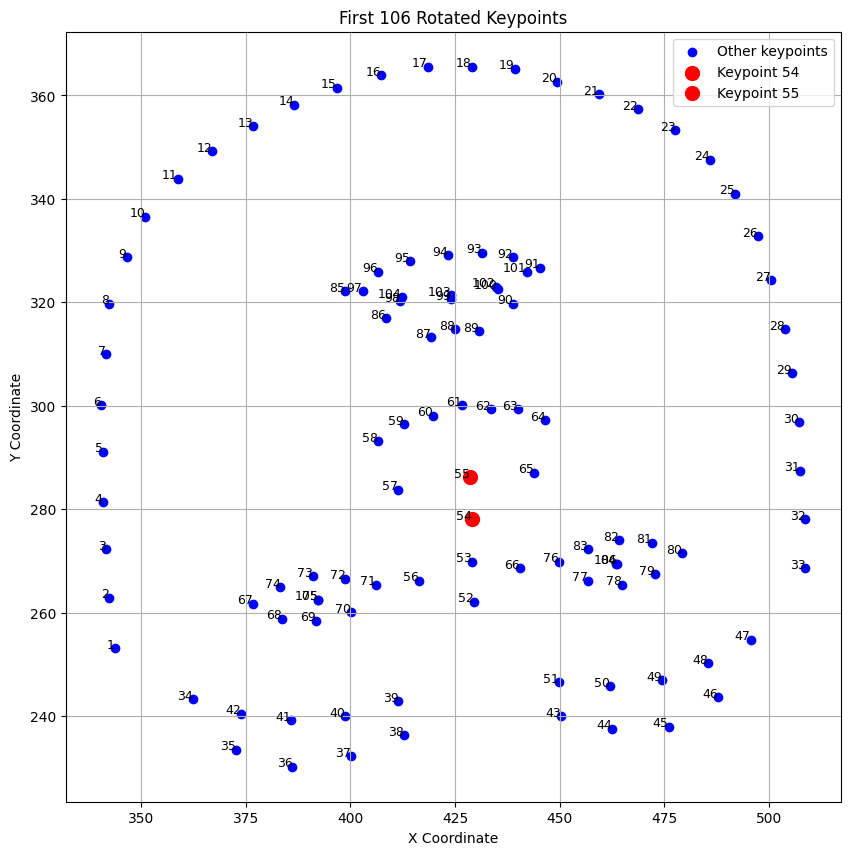

In [4]:
# figure
plt.figure(figsize=(10, 10))
x_coords = df['x_coordinate'][:106].values
y_coords = df['y_coordinate'][:106].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53 
kp_55_index = 54

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')
plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
def move_and_rotate_keypoints_updated(df):
    def get_rotation_matrix(angle):
        return np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])

    def rotate_points(points, angle):
        rotation_matrix = get_rotation_matrix(angle)
        return np.dot(points, rotation_matrix.T)

    def normalize_points(points):
        min_vals = points.min(axis=0)
        max_vals = points.max(axis=0)
        scale = max(max_vals - min_vals)
        normalized_points = 2 * ((points - min_vals) / scale) - 1
        return normalized_points

    def sum_abs_x(angle):
        rotated = rotate_points(translated_coords_np, angle)
        return np.sum(np.abs(rotated[:, 0]))
        
    result = []

    # keypoint indexes to be aligned
    align_keypoints = [52, 53, 54, 55, 17, 88, 94]

    grouped = df.groupby(['infant_id', 'frame_id'])
    
    for (infant_id, frame_id), group in tqdm(grouped, desc="Processing frames"):
        kp_54 = cp.array(group[group['keypoint_index'] == 55][['x_coordinate', 'y_coordinate']].values[0])
        
        # coordinates of the keypoints to be aligned
        keypoints_to_align = cp.array(group[group['keypoint_index'].isin(align_keypoints)][['x_coordinate', 'y_coordinate']].values)
        translated_coords = keypoints_to_align - kp_54
        translated_coords_np = translated_coords.get()
        
        # optimal angle to minimize the sum of absolute x-coordinates
        angles = np.linspace(-np.pi, np.pi, 360)
        optimal_angle = angles[np.argmin([sum_abs_x(a) for a in angles])]
        
        # translate all keypoints relative to kp_54
        all_translated_coords = cp.array(group[['x_coordinate', 'y_coordinate']].values) - kp_54
    
        all_translated_coords_np = all_translated_coords.get()
        rotated_coords = rotate_points(all_translated_coords_np, optimal_angle)
        normalized_coords = normalize_points(rotated_coords)
 
        #kp_54_index = group['keypoint_index'].values == 55
        #normalized_coords -= normalized_coords[kp_54_index.get()].reshape(1, -1)
        
        kp_52_y = normalized_coords[group['keypoint_index'].values.get() == 52][0, 1]
        kp_17_y = normalized_coords[group['keypoint_index'].values.get() == 17][0, 1]
        
        if kp_52_y < 0 or kp_17_y > 0:
            normalized_coords = rotate_points(normalized_coords, np.pi)

        transformed_group = group.copy()
        transformed_group[['x_coordinate', 'y_coordinate']] = normalized_coords
        
        result.append(transformed_group.to_pandas())
    
    return pd.concat(result).reset_index(drop=True)

transformed_df = move_and_rotate_keypoints_updated(cudf.DataFrame(df))
print(transformed_df)

Processing frames: 21923it [03:07, 116.87it/s]


         infant_id age_weeks  frame_id  keypoint_score    face_part  \
0                6     12-16        95        0.805525         Chin   
1                6     12-16        95        0.882583         Chin   
2                6     12-16        95        0.869565         Chin   
3                6     12-16        95        0.958641         Chin   
4                6     12-16        95        0.873230         Chin   
...            ...       ...       ...             ...          ...   
2327649      98773     12-16      2340        0.939092        Mouth   
2327650      98773     12-16      2340        0.958739        Mouth   
2327651      98773     12-16      2340        0.937326        Mouth   
2327652      98773     12-16      2340        0.999624  Right_Pupil   
2327653      98773     12-16      2340        1.023381   Left_Pupil   

         keypoint_index                       processed_keypoint  \
0                     1  (388.29339599609375, 264.0990244547526)   
1          

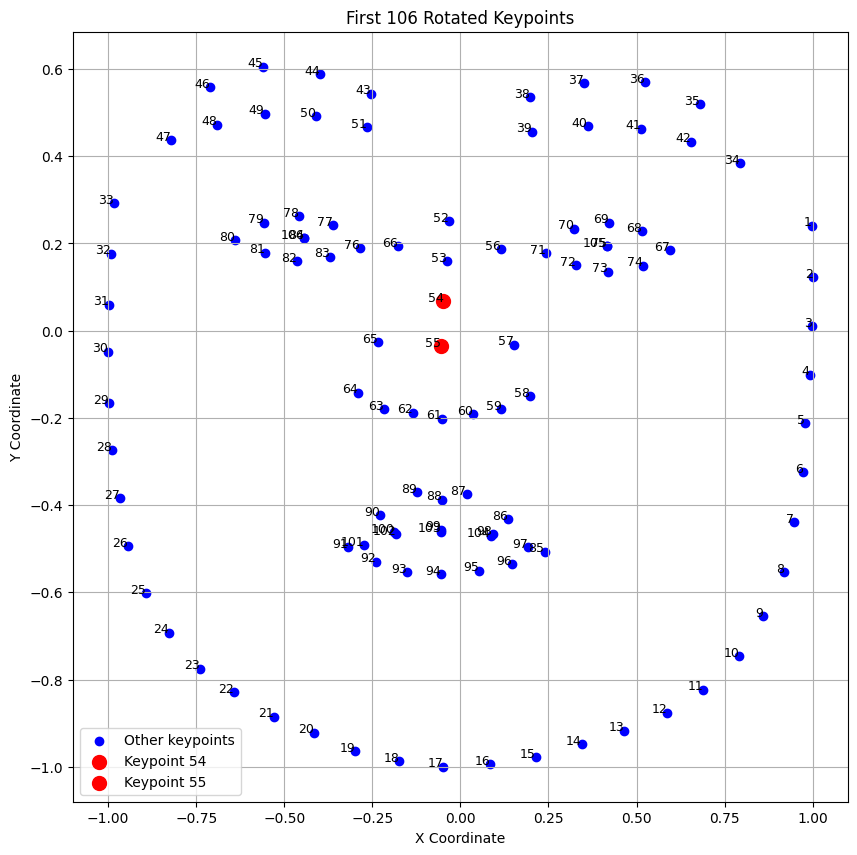

In [7]:
# figure
plt.figure(figsize=(10, 10))

x_coords = transformed_df['x_coordinate'][318:424].values
y_coords = transformed_df['y_coordinate'][318:424].values

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53  
kp_55_index = 54  

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')

plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
df.drop(['processed_keypoint'], axis=1, inplace=True)
transformed_df.drop(['processed_keypoint'], axis=1, inplace=True)


In [9]:
df.head(107)

,infant_id,age_weeks,frame_id,keypoint_score,face_part,keypoint_index,x_coordinate,y_coordinate
0,6,12-16,95,0.805525,Chin,1,343.609222,253.119980
1,6,12-16,95,0.882583,Chin,2,342.382568,262.933136
2,6,12-16,95,0.869565,Chin,3,341.564789,272.337433
3,6,12-16,95,0.958641,Chin,4,340.747040,281.332825
4,6,12-16,95,0.873230,Chin,5,340.747040,291.145996
...,...,...,...,...,...,...,...,...
102,6,12-16,95,0.954342,Mouth,103,424.158966,321.403290
103,6,12-16,95,0.937748,Mouth,104,412.301392,320.994385
104,6,12-16,95,0.967000,Right_Pupil,105,392.266174,262.524261
105,6,12-16,95,0.938191,Left_Pupil,106,463.820526,269.475250


In [25]:
transformed_df.head(107)

,infant_id,age_weeks,frame_id,keypoint_score,face_part,keypoint_index,x_coordinate,y_coordinate
0,6,12,95,0.805525,Chin,1,0.999783,0.221951
1,6,12,95,0.882583,Chin,2,1.000000,0.104002
2,6,12,95,0.869565,Chin,3,0.995973,-0.008510
3,6,12,95,0.958641,Chin,4,0.992542,-0.116183
4,6,12,95,0.873230,Chin,5,0.978239,-0.232344
...,...,...,...,...,...,...,...,...
102,6,12,95,0.954342,Mouth,103,-0.053229,-0.468933
103,6,12,95,0.937748,Mouth,104,0.087728,-0.481375
104,6,12,95,0.967000,Right_Pupil,105,0.410111,0.181549
105,6,12,95,0.938191,Left_Pupil,106,-0.447027,0.203560


In [24]:
df = transformed_df

In [26]:
# new dataframe with unique infant_id and frame_id combinations
# df['age_weeks'] = df['age_weeks'].str.split('-').str[0].astype(int)

# Create a face_feature_df DataFrame with unique entries
face_feature_df = df[['infant_id', 'age_weeks', 'frame_id']].drop_duplicates().reset_index(drop=True)

left_brow_indices = cp.array(list(range(34, 43)))
right_brow_indices = cp.array(list(range(43, 52)))
lip_pairs = [(100, 102), (99, 103), (98, 104)]
right_eye_pairs = [(79, 81), (78, 82), (77, 83)]
left_eye_pairs = [(70, 72), (69, 73), (68, 74)]

# DataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
ages = cp.array(df['age_weeks'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
y_coords = cp.array(df['y_coordinate'].values)

# Function to calculate the mean y-coordinate for specified keypoints
def calculate_mean_y_coord_cp(infant_ids,ages, frame_ids, keypoint_indices, y_coords, infant_id,age, frame_id, brow_indices):
    mask = (infant_ids == infant_id) & (ages == age) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, brow_indices))
    return y_coords[mask].mean()

# Function to calculate the mean distance between specified keypoints
def calculate_mean_distance_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age, frame_id, points):
    distances = []
    for p1, p2 in points:
        mask1 = (infant_ids == infant_id) & (ages == age) & (frame_ids == frame_id) & (keypoint_indices == p1)
        mask2 = (infant_ids == infant_id) & (ages == age) & (frame_ids == frame_id) & (keypoint_indices == p2)
        kp1 = y_coords[mask1]
        kp2 = y_coords[mask2]
        if kp1.size > 0 and kp2.size > 0:
            distance = cp.abs(kp1 - kp2)
            distances.append(distance)
    return cp.mean(cp.array(distances)) if distances else cp.nan

In [27]:
face_feature_df

,infant_id,age_weeks,frame_id
0,6,12,95
1,6,12,96
2,6,12,97
3,6,12,98
4,6,12,99
...,...,...,...
21954,98773,12,2336
21955,98773,12,2337
21956,98773,12,2338
21957,98773,12,2339


In [28]:
mean_y_coord_left_brow = []
mean_y_coord_right_brow = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating mean y-coordinates for eyebrows'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    age_numeric = face_feature_df['age_weeks'].iloc[index]
    
    mean_y_coord_left_brow.append(
        calculate_mean_y_coord_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age_numeric, frame_id, left_brow_indices).get()
    )
    mean_y_coord_right_brow.append(
        calculate_mean_y_coord_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age_numeric, frame_id, right_brow_indices).get()
    )

# Add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow

print(face_feature_df)

Calculating mean y-coordinates for eyebrows: 100%|██████████| 21959/21959 [00:51<00:00, 428.87it/s]

       infant_id  age_weeks  frame_id mean_y_coord_left_brow  \
0              6         12        95     0.4724871465776045   
1              6         12        96     0.4753695665667498   
2              6         12        97     0.8802891297919866   
3              6         12        98     0.4885552481323001   
4              6         12        99       0.89329149208977   
...          ...        ...       ...                    ...   
21954      98773         12      2336     0.9217549737856667   
21955      98773         12      2337     0.5440112970687201   
21956      98773         12      2338     0.9200475168093613   
21957      98773         12      2339     0.9200241444482887   
21958      98773         12      2340      0.539193264040898   

      mean_y_coord_right_brow  
0          0.5064274173236206  
1          0.5117551562059685  
2          0.9158130561056813  
3          0.5177011577848746  
4          0.9173461829823135  
...                       ...  
21954  

In [29]:
# calculate distances with progress tracking
right_eye_eyelid_distance = []
left_eye_eyelid_distance = []
lip_distance = []

# Iterate over each row in the face_feature_df
for index in tqdm(range(len(face_feature_df)), desc='Calculating distances for keypoints'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    age_numeric = face_feature_df['age_weeks'].iloc[index]
    
    right_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age_numeric,frame_id, right_eye_pairs).get()
    )
    left_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age_numeric, frame_id, left_eye_pairs).get()
    )
    lip_distance.append(
        calculate_mean_distance_cp(infant_ids, ages, frame_ids, keypoint_indices, y_coords, infant_id, age_numeric, frame_id, lip_pairs).get()
    )

Calculating distances for keypoints: 100%|██████████| 21959/21959 [07:19<00:00, 49.96it/s]


In [30]:
# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow
face_feature_df['right_eye_eyelid_distance'] = right_eye_eyelid_distance
face_feature_df['left_eye_eyelid_distance'] = left_eye_eyelid_distance
face_feature_df['lip_distance'] = lip_distance

# determine if the eyes and mouth are closed based on the distances
threshold_eyes = 0.035
threshold_mouth =  0.04 
face_feature_df['right_eye_closed'] = face_feature_df['right_eye_eyelid_distance'] < threshold_eyes
face_feature_df['left_eye_closed'] = face_feature_df['left_eye_eyelid_distance'] < threshold_eyes
face_feature_df['mouth_closed'] = face_feature_df['lip_distance'] < threshold_mouth

print(face_feature_df)

       infant_id  age_weeks  frame_id mean_y_coord_left_brow  \
0              6         12        95     0.4724871465776045   
1              6         12        96     0.4753695665667498   
2              6         12        97     0.8802891297919866   
3              6         12        98     0.4885552481323001   
4              6         12        99       0.89329149208977   
...          ...        ...       ...                    ...   
21954      98773         12      2336     0.9217549737856667   
21955      98773         12      2337     0.5440112970687201   
21956      98773         12      2338     0.9200475168093613   
21957      98773         12      2339     0.9200241444482887   
21958      98773         12      2340      0.539193264040898   

      mean_y_coord_right_brow right_eye_eyelid_distance  \
0          0.5064274173236206       0.08307534303849777   
1          0.5117551562059685       0.07788990654639294   
2          0.9158130561056813       0.0804964274936457

In [33]:
# 43 - 47 upper right brow 
# 48 - 51 lower right brow
# 34 - 38 upper left brow 
# 39 - 42 lower left brow
# 67 - 71 upper left eyelid
# 72 - 74 lower left eyelid
# 76 - 80 upper right eyelid
# 81 - 83 lower right eyelid
# 85 - 91 upper outer lip
# 92 - 97 lower outer lip
# 98 - 101 upper inner lip
# 102 - 104 lower inner lip 

# function for curvatures
def calculate_curvature_cp(infant_ids, ages, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, age, frame_id, indices):
    # Create a mask to filter relevant coordinates
    mask = (infant_ids == infant_id) & (ages == age) & (frame_ids == frame_id) & cp.isin(keypoint_indices, indices)
    x_coords_filtered = x_coords[mask]
    y_coords_filtered = y_coords[mask]
    
    if len(x_coords_filtered) < 3 or len(y_coords_filtered) < 3:
        return cp.nan  # Need at least 3 points to calculate second derivative
    
    # Compute the second derivatives
    y_second_derivative = cp.gradient(cp.gradient(y_coords_filtered, x_coords_filtered), x_coords_filtered)
    # Compute the mean of the second derivatives
    curvature = cp.mean(y_second_derivative)
    
    return curvature

In [34]:
# Keypoint indices for the specified face parts
indices_dict = {
    'upper_right_brow': cp.array(list(range(43, 48))),
    'lower_right_brow': cp.array(list(range(48, 52))),
    'upper_left_brow': cp.array(list(range(34, 39))),
    'lower_left_brow': cp.array(list(range(39, 43))),
    'upper_left_eyelid': cp.array(list(range(67, 72))),
    'lower_left_eyelid': cp.array(list(range(72, 75))),
    'upper_right_eyelid': cp.array(list(range(76, 81))),
    'lower_right_eyelid': cp.array(list(range(81, 84))),
    'upper_outer_lip': cp.array(list(range(85, 92))),
    'lower_outer_lip': cp.array(list(range(92, 98))),
    'upper_inner_lip': cp.array(list(range(98, 102))),
    'lower_inner_lip': cp.array(list(range(102, 105)))
}

# DataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
ages = cp.array(df['age_weeks'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
x_coords = cp.array(df['x_coordinate'].values)
y_coords = cp.array(df['y_coordinate'].values)

# Initialize dictionaries to store curvature results
curvature_results = {key: [] for key in indices_dict.keys()}

for index in tqdm(range(len(face_feature_df)), desc='Calculating curvatures for specified face parts'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    age_numeric = face_feature_df['age_weeks'].iloc[index]
    
    for part, indices in indices_dict.items():
        curvature = calculate_curvature_cp(infant_ids, ages, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, age_numeric, frame_id, indices).get()
        curvature_results[part].append(curvature)

Calculating curvatures for specified face parts:   0%|          | 4/21959 [00:00<09:33, 38.28it/s]

Calculating curvatures for specified face parts: 100%|██████████| 21959/21959 [09:05<00:00, 40.26it/s]


In [35]:
for part, curvatures in curvature_results.items():
    face_feature_df[f'curvature_{part}'] = curvatures

print(face_feature_df)

       infant_id  age_weeks  frame_id mean_y_coord_left_brow  \
0              6         12        95     0.4724871465776045   
1              6         12        96     0.4753695665667498   
2              6         12        97     0.8802891297919866   
3              6         12        98     0.4885552481323001   
4              6         12        99       0.89329149208977   
...          ...        ...       ...                    ...   
21954      98773         12      2336     0.9217549737856667   
21955      98773         12      2337     0.5440112970687201   
21956      98773         12      2338     0.9200475168093613   
21957      98773         12      2339     0.9200241444482887   
21958      98773         12      2340      0.539193264040898   

      mean_y_coord_right_brow right_eye_eyelid_distance  \
0          0.5064274173236206       0.08307534303849777   
1          0.5117551562059685       0.07788990654639294   
2          0.9158130561056813       0.0804964274936457

In [36]:
face_feature_df.head(10)

,infant_id,age_weeks,frame_id,mean_y_coord_left_brow,mean_y_coord_right_brow,right_eye_eyelid_distance,left_eye_eyelid_distance,lip_distance,right_eye_closed,left_eye_closed,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,6,12,95,0.4724871465776045,0.5064274173236206,0.08307534303849777,0.08508583489269521,0.00806682485557205,False,False,...,-2.3672036909519028,-0.6773427804696341,-3.26063498676748,1.6775910981343076,-3.0203437685908696,1.5113702715844353,-2.185504029400209,2.588250809556618,-1.086333554085747,-0.4399080206835942
1,6,12,96,0.4753695665667498,0.5117551562059685,0.07788990654639294,0.08471038046697481,0.008031253031221874,False,False,...,-2.3405333161725945,-0.6060516685348978,-3.0765302682450164,1.3906280282008376,-2.5858630740303292,1.4175996613083142,-2.159087021191144,2.9663006295348704,-1.1204296099986708,-0.3122082044476175
2,6,12,97,0.8802891297919866,0.9158130561056813,0.08049642749364579,0.08564686712714265,0.004603837720924317,False,False,...,-2.450055348959918,-0.6092645872837081,-3.213924789356639,1.6976016480802558,-2.921114769606283,1.655098275017654,-2.135315369267244,2.593371464931686,-1.0473029182881723,-0.41657222747451855
3,6,12,98,0.4885552481323001,0.5177011577848746,0.08117731262859795,0.0915374309382404,0.004840121539920379,False,False,...,-2.3078340875745202,-0.5994168639028463,-3.1874060203500587,1.5712585397504542,-2.972906973569947,1.7079478248726296,-2.152611528367735,3.1529918876464857,-1.1255129731675877,-0.4403151317876044
4,6,12,99,0.89329149208977,0.9173461829823135,0.08292489462079651,0.08647061937386132,0.004850378731113161,False,False,...,-2.396236241753529,-0.6863289527109083,-2.881380090031892,1.621332711617831,-3.2406204263904357,1.1355617731220826,-2.0684859363201924,2.7107482922414605,-1.0198444482984603,-0.4143242002927785
5,6,12,100,0.8827558133288307,0.9145735460963331,0.0828358254259856,0.08460332383015319,0.006448106077368752,False,False,...,-2.4378078592245496,-0.6901062876416588,-3.0899418167391888,1.3739547947442077,-3.1364293932627083,1.5137202331243884,-2.266590510614652,3.032937103197245,-1.092059701111204,-0.440963759131699
6,6,12,101,0.8747932200234865,0.9107706445602379,0.08449643466707717,0.08480844251360631,0.008079609161692591,False,False,...,-2.6599664215213994,-0.7837447327752924,-2.9260649089101194,1.359640904530994,-3.446150648179824,1.1361532051270584,-2.1695320512623306,2.9781429760524474,-1.231915452883643,-0.4117003622018785
7,6,12,102,0.8793725479503854,0.9141964620939365,0.08451258828058254,0.08466842712004057,0.008222044002461855,False,False,...,-2.638837347849482,-0.7014470897422678,-3.087569515032337,1.361874647549597,-3.2891553515138647,1.1699917448792148,-2.3640139186258873,2.3385674316267573,-1.2604868300876266,-0.4152333255831408
8,6,12,103,0.4810894351897937,0.5130010349219172,0.08636336618153988,0.08622156138695414,0.008080459438637297,False,False,...,-2.5266891056911884,-0.7005117103741542,-3.117091470841241,1.8574002640716536,-3.302888414383419,1.6319029101937115,-2.060307969458099,2.3644994814345437,-1.0971229960434572,-0.4119571379294389
9,6,12,104,0.48177303262848753,0.5101379215370526,0.07958146810979143,0.08780042157029018,0.008219024363304572,False,False,...,-2.5365473233002076,-0.7472398918424925,-3.2669214854019493,1.6071384895274414,-2.9598321297242345,1.1362652094498091,-2.213283539868069,2.954654953184194,-1.2403720353819767,-0.41214289081896793


In [37]:
face_feature_df.to_csv('face_features_with_curvatures_panda2.csv', index=False)

In [75]:
# function to calculate displacement manually
def calculate_manual_displacement(group):
    group['shifted_x'] = group['x_coordinate'].shift(1)
    group['shifted_y'] = group['y_coordinate'].shift(1)

    group['interframe_x_displacement'] = group['x_coordinate'] -  group['shifted_x']
    group['interframe_y_displacement'] =  group['y_coordinate'] - group['shifted_y']

    group['interframe_x_displacement'] = group['interframe_x_displacement'].fillna(0)
    group['interframe_y_displacement'] = group['interframe_y_displacement'].fillna(0)
    
    return group

# displacement for all keypoints
df = df.groupby(['infant_id','ages_weeks', 'keypoint_index']).apply(calculate_manual_displacement).reset_index(drop=True)
df = df.drop(columns = ['shifted_x','shifted_y'])
df.loc[df['frame_id'] == 0, ['interframe_x_displacement', 'interframe_y_displacement']] = 0.0

print(df.head(1320))

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 6890 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


      infant_id  frame_id  keypoint_score face_part  keypoint_index  \
0             0         0        0.577999      Chin               1   
1             0         1        0.514304      Chin               1   
2             0         2        0.493515      Chin               1   
3             0         3        0.466503      Chin               1   
4             0         4        0.473813      Chin               1   
...         ...       ...             ...       ...             ...   
1315          0      1315        0.711513      Chin               1   
1316          0      1316        0.703581      Chin               1   
1317          0      1317        0.721716      Chin               1   
1318          0      1318        0.754950      Chin               1   
1319          0         0        0.752206      Chin               2   

      x_coordinate  y_coordinate  interframe_x_displacement  \
0       351.601135    463.115295                   0.000000   
1       349.961029   

In [77]:
mean_displacements = df.groupby(['infant_id','ages_weeks' ,'keypoint_index'])[['interframe_x_displacement', 'interframe_y_displacement']].mean().reset_index()
mean_displacements.rename(columns={
    'interframe_x_displacement': 'mean_x_displacement_keypoint',
    'interframe_y_displacement': 'mean_y_displacement_keypoint'
}, inplace=True)

# calculating the average confidence per keypoint per infant, based on keypoint_scores 
average_confidence = df.groupby(['infant_id','ages_weeks','keypoint_index'])['keypoint_score'].mean().reset_index()
average_confidence.rename(columns={'keypoint_score': 'average_confidence_keypoint'}, inplace=True)
face_parts = df[['infant_id','ages_weeks' ,'keypoint_index', 'face_part']].drop_duplicates()

# merge all metrics
metrics_df = cudf.merge(mean_displacements, average_confidence, on=['infant_id','ages_weeks', 'keypoint_index'])
metrics_df = cudf.merge(metrics_df, face_parts, on=['infant_id','ages_weeks','keypoint_index'])

metrics_df = metrics_df.sort_values(by=['infant_id','ages_weeks', 'keypoint_index'])
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df.head(107))

     infant_id  keypoint_index  mean_x_displacement_keypoint  \
0            0               1                     -0.108792   
1            0               2                     -0.104563   
2            0               3                     -0.100725   
3            0               4                     -0.097220   
4            0               5                     -0.093938   
..         ...             ...                           ...   
102          0             103                     -0.091342   
103          0             104                     -0.090394   
104          0             105                     -0.109413   
105          0             106                     -0.115715   
106          1               1                      0.000633   

     mean_y_displacement_keypoint  average_confidence_keypoint    face_part  
0                        0.010605                     0.495667         Chin  
1                        0.009601                     0.778484         Chin

In [76]:
df.to_csv('displacements_panda2.csv', index=False)

In [78]:
metrics_df.to_csv('keypoints_metrics_panda2.csv', index=False)